In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [10]:
def obrada(month, step):
    #step definira koja je granica za rupu
    #čitanje csva, izračun prvog i zadnjeg 'trenutka' mjeseca
    df=pd.read_csv("{}_2022.csv".format(month),usecols=['id','time'], encoding='latin1')
    end=pd.to_datetime("2022-{}-01 23:59:59".format(month+1))-pd.Timedelta(days=1)
    beginning=pd.to_datetime("2022-{}-01 00:00:00".format(month))
    #nijedan podatak nije zabiljezen u mjesecu
    if df.empty:
        df=pd.DataFrame({'start-time':[beginning], 'end-time':[end], 'duration':[end-beginning]})
        return df
    df['time']=pd.to_datetime(df['time'])
    #izračun razmaka među mjerenjima
    df['diff'] = df['time'].diff(periods=1)
    #izračun razmaka između poč. mjeseca i prvog mjerenja
    df.loc[0,'diff']=df.loc[0, 'time'] - beginning
    #izračun razmaka između kraja mjeseca i zadnjeg mjerenja
    df.loc[len(df)] = {'diff':end - df.loc[len(df)-1, 'time'], 'time' : end}
    df['index'] = range(len(df))
    #filtiranje samo redaka čiji je diff veci od odabranog step-a (i njihovih prethodnika)
    df4=df[df['diff'] > step]
    previous_row = df4['index'] - 1
    result = pd.concat([df[df['index'].isin(previous_row) ], df4])
    result.sort_index(inplace=True, ignore_index=True)

    if(result.empty):
        print("nema rupa")
        return result
    if result.loc[0,'index']==0:
        #prvi red ima rupu od poč. mjeseca
        new_df=pd.DataFrame({'start-time':[beginning], 'end-time':[result.loc[0,'time']], 'duration':[result.loc[0,'diff']]})
        new_df=pd.concat([new_df,pd.DataFrame({
        'start-time': result['time'].iloc[1::2].reset_index(drop=True),
        'end-time': result['time'].iloc[2::2].reset_index(drop=True),
        'duration': result['diff'].iloc[2::2].reset_index(drop=True)
        })], ignore_index=True)
    else:
        #nema rupe od poč. mjeseca, uzimam parove redaka
        new_df = pd.DataFrame({
            'start-time': result['time'].iloc[0::2].reset_index(drop=True),
            'end-time': result['time'].iloc[1::2].reset_index(drop=True),
            'duration': result['diff'].iloc[1::2].reset_index(drop=True)
        })
    return new_df

end=pd.to_datetime("2022-{}-01 23:59:59".format(month+1))-pd.Timedelta(days=1)
beginning=pd.to_datetime("2022-{}-01 00:00:00".format(month))
all_timestamps = pd.date_range(start=beginning, end=end, freq='120S')


is_within_interval_list = [
    any((timestamp >= row['time1']) and (timestamp <= row['time2']) for i, row in df.iterrows())
    for timestamp in all_timestamps
]

plt.plot(all_timestamps, is_within_interval_list)
tick_positions = pd.date_range(start=beginning, end=end, freq='1D')
plt.xticks(tick_positions, [timestamp.strftime('%Y-%m-%d') for timestamp in tick_positions], rotation=45, ha='right', fontsize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)  

plt.xlabel('Timestamp', fontsize=10) 
plt.ylabel('Is within interval (1 or 0)')
plt.title('Scatter Plots of Timestamps within Intervals for the Entire Month')

fig = plt.gcf()
fig.set_size_inches(20, 6)  # Adjust the width and height as needed
plt.savefig('responsive_plot.png', dpi=300, bbox_inches='tight')

plt.show()

In [14]:
def make_graph(month, step):
    df=obrada(month,step)
    print("{}. mjesec".format(month))
    print(df)
    end=pd.to_datetime("2022-{}-01 23:59:59".format(month+1))-pd.Timedelta(days=1)
    beginning=pd.to_datetime("2022-{}-01 00:00:00".format(month))
    all_timestamps = pd.date_range(start=beginning, end=end, freq='120S')
    is_within_interval_list = [
        any((timestamp >= row['start-time']) and (timestamp <= row['end-time']) for i, row in df.iterrows())
        for timestamp in all_timestamps
    ]
    fig, ax = plt.subplots()  # Create a new figure and axis for each month
    ax.plot(all_timestamps, is_within_interval_list, linewidth=1)
    tick_positions = pd.date_range(start=beginning, end=end, freq='1D')
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([timestamp.strftime('%Y-%m-%d') for timestamp in tick_positions], rotation=45, ha='right', fontsize=8)
    
    ax.set_xlabel('Timestamp', fontsize=10)
    ax.set_ylabel('1 - rupa, 0 - zapis')
    ax.set_title("Graf rupa u podacima većih od {} za {}. mjesec".format(step, month))
    
    fig.set_size_inches(20, 6)  # Adjust the width and height as needed
    plt.savefig("{}m_graph.png".format(month), dpi=600, bbox_inches='tight')
    
    #plt.show()
    return

7. mjesec
           start-time            end-time         duration
0 2022-07-09 14:50:13 2022-07-11 07:33:29  1 days 16:43:16
1 2022-07-12 15:38:47 2022-07-14 08:33:50  1 days 16:55:03
2 2022-07-15 13:17:01 2022-07-15 13:18:18  0 days 00:01:17
3 2022-07-21 16:25:38 2022-07-31 23:59:59 10 days 07:34:21


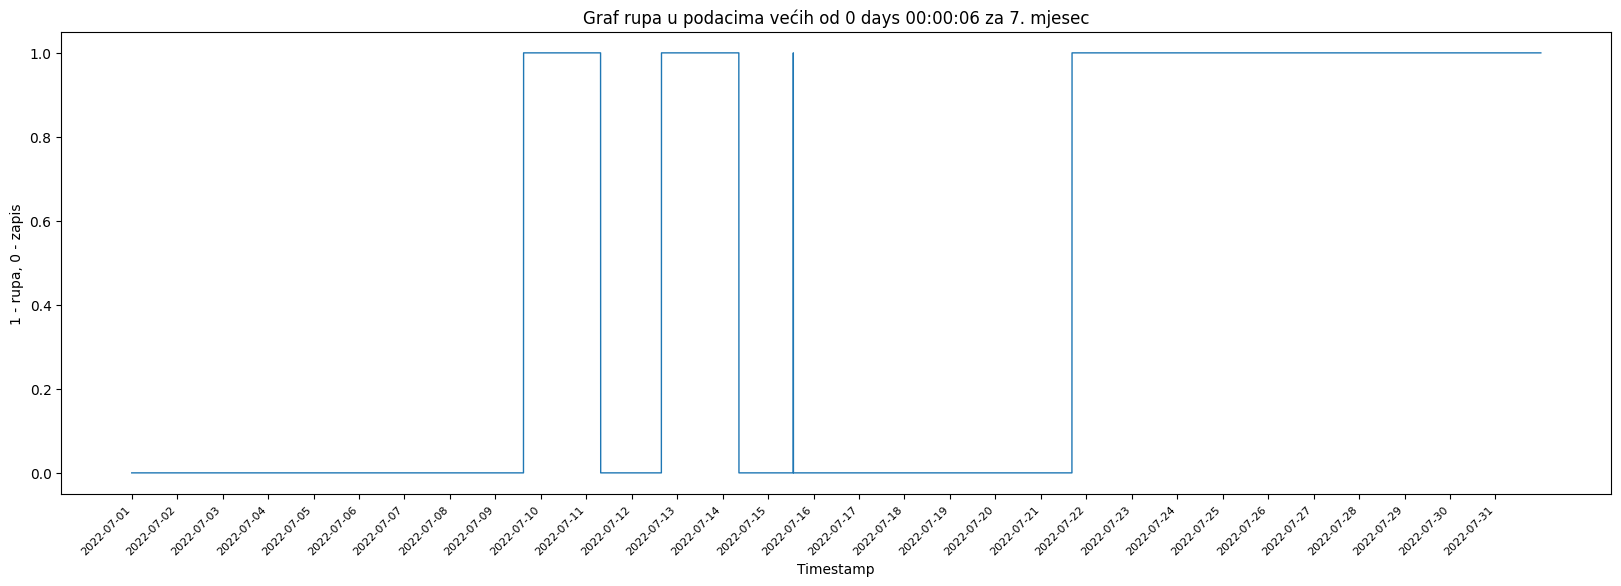

In [15]:
step=pd.to_timedelta('00:00:06')
#make_graph(7,step)
for i in range(4,12):
   make_graph(i, step)